<a href="https://colab.research.google.com/github/geun-hyoung/Forecasting_the_number_of_complaints_received/blob/main/Data_Clenaing%26EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Load(Concat)& Library 

In [1]:
# google drive
from google.colab import drive
drive.mount('/content/drive') # Connect to drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import folium
from folium import plugins
from folium.features import DivIcon

import json
import requests

In [3]:
# 112 factor = 112 신고 접수량의 융합 요소 데이터
fusion_element = pd.concat([
    pd.read_csv('/content/drive/MyDrive/데이터마이닝/112factor_19.csv', encoding = 'cp949'),
    pd.read_csv('/content/drive/MyDrive/데이터마이닝/112factor_20.csv', encoding = 'cp949'),
    pd.read_csv('/content/drive/MyDrive/데이터마이닝/112factor_21.csv', encoding = 'cp949')], axis = 0)

# korean_112 = 112신고접수량 데이터
report_data = pd.concat([ 
    pd.read_csv('/content/drive/MyDrive/데이터마이닝/Korea_112_19.csv', encoding = 'cp949'),
    pd.read_csv('/content/drive/MyDrive/데이터마이닝/Korea_112_20.csv', encoding = 'cp949'),
    pd.read_csv('/content/drive/MyDrive/데이터마이닝/Korea_112_21.csv', encoding = 'cp949')], axis = 0)

print("융합 요소 데이터 갯수:", fusion_element.shape)
print("신고 데이터 갯수:", report_data.shape)

융합 요소 데이터 갯수: (9934, 28)
신고 데이터 갯수: (9946, 43)


In [4]:
# 두 데이터셋이 공통 값인데도 불구하고 맞지 않은 경우가 있어, 신고접수량 데이터를 기준으로 통일
fusion_element.drop(labels =['RPRT_CASCNT_WHOL', 'RPRT_SEX_MALE',
       'RPRT_SEX_FMLE', 'RPRT_SEX_UNKWN', 'RPRT_SEX_ETC',
       'ACPT_EMERG_TYPE_EMERG', 'ACPT_EMERG_TYPE_IMPRTNC',
       'ACPT_EMERG_TYPE_GNRL', 'ACPT_EMERG_TYPE_CVAPP', 'ACPT_EMERG_TYPE_ETC',
       'OCRN_DOTW_SNDD', 'OCRN_DOTW_MON', 'OCRN_DOTW_TUE', 'OCRN_DOTW_WED',
       'OCRN_DOTW_THU', 'OCRN_DOTW_FRI', 'OCRN_DOTW_SAT', 'MNTH_AVE_INCOME_AMT', 
       'TOTL_RESID_PUL_CNT'], axis = 1, inplace = True)

In [5]:
# 신고 접수량 데이터셋에는 고성이 X
fusion_element.drop(index = fusion_element[fusion_element['PLCST_NM'] == '고성'].index, axis = 0, inplace = True)

In [6]:
# 112 융합 요소 데이터와 + 112 신고 접수 데이터 결합
df = pd.merge(report_data, fusion_element, how = 'left', on = ("ACPT_YM", "PLCST_NM"))

In [7]:
# 결측치 제거
df.dropna(axis=0,inplace = True)

In [8]:
# 전체 데이터 셋
df.shape

(9898, 50)

In [9]:
# Time 형식으로 변환 과정
def change_dt(values):
    return str(values)[0:4] + '-' + str(values)[4:] 

df['ACPT_YM'] = df['ACPT_YM'].apply(change_dt)

# 데이터 형식 변경
import datetime as dt
df['ACPT_YM'] = df['ACPT_YM'].apply(lambda x: dt.datetime.strptime(x, "%Y-%m"))

In [10]:
df.head()

,ACPT_YM,PLCST_NM,RPRT_CASCNT_WHOL,RPRT_SEX_MALE,RPRT_SEX_FMLE,RPRT_SEX_UNKWN,RPRT_SEX_ETC,ACPT_EMERG_TYPE_EMERG,ACPT_EMERG_TYPE_IMPRTNC,ACPT_EMERG_TYPE_GNRL,...,OCRN_TIZN_21,OCRN_TIZN_22,OCRN_TIZN_23,CFINC_DSTVC,CFINC_DTVC,CFINC_MRDR,CFINC_SVLNC,CFINC_SUCD,CFINC_INCVLC,CFINC_ETC
0,2019-01-01,ETC,489051,164430,90192,73257,161172,6,248,977,...,26575,24972,22933,114.0,30.0,3.0,18.0,28.0,304.0,488554.0
1,2019-01-01,서울노원,6826,3836,2088,899,3,93,1697,3681,...,345,383,437,254.0,17.0,0.0,17.0,44.0,329.0,6165.0
2,2019-01-01,서울방배,2202,1276,696,230,0,18,521,1193,...,117,138,188,28.0,13.0,0.0,1.0,19.0,71.0,2070.0
3,2019-01-01,서울중랑,7413,3728,2713,970,2,62,1587,3805,...,485,427,497,188.0,16.0,0.0,22.0,49.0,346.0,6792.0
4,2019-01-01,화성동탄,5324,3159,1398,765,2,27,1539,2694,...,235,291,325,173.0,22.0,3.0,5.0,24.0,214.0,4883.0


In [11]:
df.info() # 경찰서명을 제외하고는 정수형

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9898 entries, 0 to 9945
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ACPT_YM                  9898 non-null   datetime64[ns]
 1   PLCST_NM                 9898 non-null   object        
 2   RPRT_CASCNT_WHOL         9898 non-null   int64         
 3   RPRT_SEX_MALE            9898 non-null   int64         
 4   RPRT_SEX_FMLE            9898 non-null   int64         
 5   RPRT_SEX_UNKWN           9898 non-null   int64         
 6   RPRT_SEX_ETC             9898 non-null   int64         
 7   ACPT_EMERG_TYPE_EMERG    9898 non-null   int64         
 8   ACPT_EMERG_TYPE_IMPRTNC  9898 non-null   int64         
 9   ACPT_EMERG_TYPE_GNRL     9898 non-null   int64         
 10  ACPT_EMERG_TYPE_CVAPP    9898 non-null   int64         
 11  ACPT_EMERG_TYPE_ETC      9898 non-null   int64         
 12  OCRN_DOTW_SNDD           9898 non-

In [12]:
df.describe()

,RPRT_CASCNT_WHOL,RPRT_SEX_MALE,RPRT_SEX_FMLE,RPRT_SEX_UNKWN,RPRT_SEX_ETC,ACPT_EMERG_TYPE_EMERG,ACPT_EMERG_TYPE_IMPRTNC,ACPT_EMERG_TYPE_GNRL,ACPT_EMERG_TYPE_CVAPP,ACPT_EMERG_TYPE_ETC,...,OCRN_TIZN_21,OCRN_TIZN_22,OCRN_TIZN_23,CFINC_DSTVC,CFINC_DTVC,CFINC_MRDR,CFINC_SVLNC,CFINC_SUCD,CFINC_INCVLC,CFINC_ETC
count,9898.000000,9898.000000,9898.000000,9898.000000,9898.000000,9898.000000,9898.000000,9898.000000,9898.000000,9898.000000,...,9898.000000,9898.000000,9898.000000,9898.000000,9898.00000,9898.000000,9898.000000,9898.000000,9898.000000,9898.000000
mean,5648.042029,2644.814609,1370.752172,1178.406446,391.214993,30.671550,778.910891,2070.778642,295.580824,2472.100121,...,310.415538,338.194989,309.581734,70.074055,16.09800,0.167003,8.014245,30.231663,148.643463,5481.298242
std,34306.174987,11193.434015,5685.004710,11745.609518,8283.407417,46.269736,889.379771,2098.271567,324.791845,32776.677460,...,1743.267823,1736.642812,1538.530219,79.534573,21.91234,0.580139,10.681085,33.002536,148.274493,34995.066155
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,797.000000,429.000000,212.000000,158.000000,0.000000,5.000000,179.000000,406.000000,70.000000,114.000000,...,42.000000,43.000000,37.000000,12.000000,1.00000,0.000000,1.000000,7.000000,27.000000,759.000000
50%,3217.000000,1753.000000,908.500000,493.000000,0.000000,19.000000,574.000000,1762.000000,216.000000,448.000000,...,178.000000,196.000000,181.500000,51.000000,8.00000,0.000000,4.000000,24.000000,120.000000,3013.000000
75%,5579.750000,3060.000000,1611.000000,870.000000,1.000000,42.000000,1113.000000,3169.000000,434.000000,772.000000,...,322.000000,361.000000,339.000000,107.000000,24.00000,0.000000,12.000000,44.000000,229.000000,5253.250000
max,749775.000000,214290.000000,106132.000000,424422.000000,225825.000000,910.000000,17171.000000,40551.000000,6150.000000,689325.000000,...,36502.000000,39912.000000,32488.000000,1363.000000,296.00000,13.000000,139.000000,638.000000,2280.000000,928793.000000


In [13]:
# 묘사 결과 최댓값이 이상치 -> 제거
df.drop(index = df[df['PLCST_NM'] == 'ETC'].index, axis = 0, inplace = True)

In [14]:
df.describe()

,RPRT_CASCNT_WHOL,RPRT_SEX_MALE,RPRT_SEX_FMLE,RPRT_SEX_UNKWN,RPRT_SEX_ETC,ACPT_EMERG_TYPE_EMERG,ACPT_EMERG_TYPE_IMPRTNC,ACPT_EMERG_TYPE_GNRL,ACPT_EMERG_TYPE_CVAPP,ACPT_EMERG_TYPE_ETC,...,OCRN_TIZN_21,OCRN_TIZN_22,OCRN_TIZN_23,CFINC_DSTVC,CFINC_DTVC,CFINC_MRDR,CFINC_SVLNC,CFINC_SUCD,CFINC_INCVLC,CFINC_ETC
count,9862.000000,9862.000000,9862.000000,9862.000000,9862.000000,9862.000000,9862.000000,9862.000000,9862.000000,9862.000000,...,9862.000000,9862.000000,9862.000000,9862.000000,9862.000000,9862.000000,9862.000000,9862.000000,9862.000000,9862.000000
mean,3598.984892,1979.027378,1032.232407,587.010951,0.631515,29.636788,756.719631,2020.241939,287.543805,504.842730,...,206.420097,235.363314,218.043095,67.928919,15.709694,0.159704,7.837964,29.363212,145.412594,3400.508213
std,2980.152462,1689.791985,870.065741,499.988814,1.315426,38.789493,705.059965,1734.782136,263.785835,440.307007,...,178.353725,216.810369,199.784414,66.329119,20.302234,0.560639,10.052418,26.768784,133.851795,2847.960792
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,792.000000,427.250000,211.000000,157.000000,0.000000,5.000000,179.000000,404.250000,70.000000,114.000000,...,42.000000,43.000000,37.000000,12.000000,1.000000,0.000000,1.000000,7.000000,26.250000,755.250000
50%,3195.500000,1741.500000,903.000000,491.000000,0.000000,18.000000,572.000000,1758.000000,215.000000,446.000000,...,177.000000,195.000000,180.000000,51.000000,8.000000,0.000000,4.000000,24.000000,119.500000,2991.000000
75%,5535.750000,3042.750000,1603.000000,865.750000,1.000000,41.000000,1104.750000,3162.750000,432.000000,768.000000,...,320.000000,359.000000,337.000000,106.000000,24.000000,0.000000,11.000000,43.750000,228.000000,5218.750000
max,14873.000000,11681.000000,4552.000000,5351.000000,16.000000,598.000000,6858.000000,9183.000000,1478.000000,5650.000000,...,965.000000,1355.000000,1149.000000,505.000000,179.000000,13.000000,92.000000,295.000000,971.000000,19442.000000


In [15]:
# 연도별, 달별 데이터 활용 시 사용하기 위해
df['Year'] = df['ACPT_YM'].dt.year 
df['Month'] = df['ACPT_YM'].dt.month 

In [16]:
df = df.sort_values(by = ["ACPT_YM", "PLCST_NM"])
df = df.reset_index(drop = True)

In [28]:
list(df.columns)

['ACPT_YM',
 'PLCST_NM',
 'RPRT_CASCNT_WHOL',
 'RPRT_SEX_MALE',
 'RPRT_SEX_FMLE',
 'RPRT_SEX_UNKWN',
 'RPRT_SEX_ETC',
 'ACPT_EMERG_TYPE_EMERG',
 'ACPT_EMERG_TYPE_IMPRTNC',
 'ACPT_EMERG_TYPE_GNRL',
 'ACPT_EMERG_TYPE_CVAPP',
 'ACPT_EMERG_TYPE_ETC',
 'OCRN_DOTW_SNDD',
 'OCRN_DOTW_MON',
 'OCRN_DOTW_TUE',
 'OCRN_DOTW_WED',
 'OCRN_DOTW_THU',
 'OCRN_DOTW_FRI',
 'OCRN_DOTW_SAT',
 'OCRN_TIZN_00',
 'OCRN_TIZN_01',
 'OCRN_TIZN_02',
 'OCRN_TIZN_03',
 'OCRN_TIZN_04',
 'OCRN_TIZN_05',
 'OCRN_TIZN_06',
 'OCRN_TIZN_07',
 'OCRN_TIZN_08',
 'OCRN_TIZN_09',
 'OCRN_TIZN_10',
 'OCRN_TIZN_11',
 'OCRN_TIZN_12',
 'OCRN_TIZN_13',
 'OCRN_TIZN_14',
 'OCRN_TIZN_15',
 'OCRN_TIZN_16',
 'OCRN_TIZN_17',
 'OCRN_TIZN_18',
 'OCRN_TIZN_19',
 'OCRN_TIZN_20',
 'OCRN_TIZN_21',
 'OCRN_TIZN_22',
 'OCRN_TIZN_23',
 'CFINC_DSTVC',
 'CFINC_DTVC',
 'CFINC_MRDR',
 'CFINC_SVLNC',
 'CFINC_SUCD',
 'CFINC_INCVLC',
 'CFINC_ETC',
 'Year',
 'Month']

In [17]:
# 전체 데이터셋
df.to_csv('/content/drive/MyDrive/데이터마이닝/total_dataset_report_112.csv', encoding = 'cp949')

In [18]:
# 전체 데이터 연도별 분리
df_19 = df[df['Year'] == 2019]
df_20 = df[df['Year'] == 2020]
df_21 = df[df['Year'] == 2021]

# 반복문 활용 시
div_year = [df_19, df_20, df_21]

In [19]:
# 연도, 달, 주
year = df.Year.unique()
month = df.Month.unique()

# 열값중 요일별 사건 발생
week = ['OCRN_DOTW_SNDD', 'OCRN_DOTW_MON', 'OCRN_DOTW_TUE', 'OCRN_DOTW_WED', 
        'OCRN_DOTW_THU', 'OCRN_DOTW_FRI', 'OCRN_DOTW_SAT']

# 그냥 열값 리스트에 저장하기 위해
hours = ['OCRN_TIZN_0' + str(i) for i in range(0, 10)] + ['OCRN_TIZN_' + str(i) for i in range(10, 24)]

time = [i for i in range(24)]

### 전국 전체 데이터셋 시각화

In [20]:
# 참조 지점, 아래 코드가 한글 사용하기 위함인데, 코드 돌리고 런타임 다시 시작하고 셀 전체 다시 실행해야함 
# matplotlib 한글 깨짐 현상 해결
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

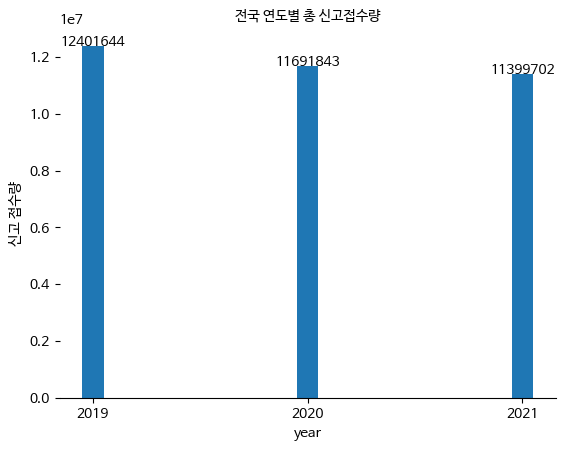

In [35]:
year_report = [arr['RPRT_CASCNT_WHOL'].sum() for arr in div_year]

plt.rc('font', family='NanumBarunGothic') 
plt.bar(year, [arr['RPRT_CASCNT_WHOL'].sum() for arr in div_year], 
        align='center', width = 0.1, linewidth=5, tick_label=year)

for i, v in enumerate(year):
  plt.text(v, year_report[i], year_report[i], horizontalalignment = 'center')

plt.rc('font', family='NanumBarunGothic') 
plt.title('전국 연도별 총 신고접수량', fontsize = 10)
plt.xlabel('year', fontsize = 10)
plt.ylabel('신고 접수량', fontsize = 10)

plt.gca().spines['right'].set_visible(False) #오른쪽 테두리 제거
plt.gca().spines['top'].set_visible(False) #위 테두리 제거
plt.gca().spines['left'].set_visible(False) #왼쪽 테두리 제거

# plt.plot(year, year_report, color='b',linestyle='--', marker='o') ## 선 그래프 출력

plt.show()

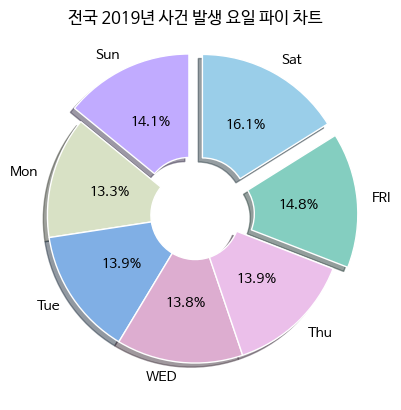

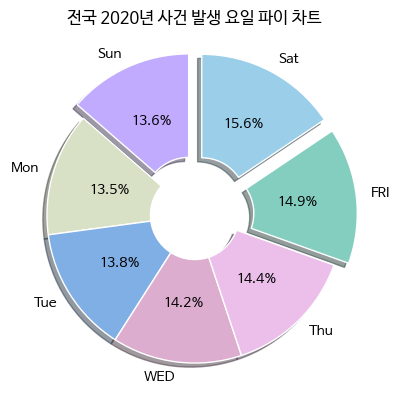

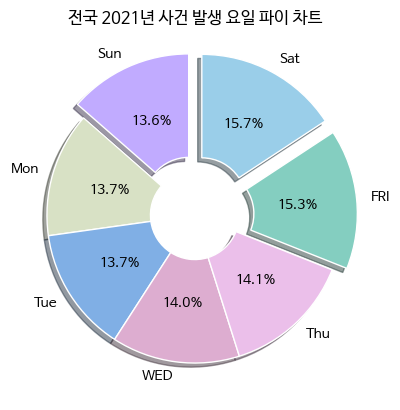

In [34]:
def draw_pieplot(year_df, year):
  colors = ['#c1abff', '#d8e1c5', '#80afe5', '#ddadd0', '#ebbfea', 
            '#84cec0', '#9acee9', '#d6c2b6', '#d48c9d', '#dcf6c5']
  ratio = [year_df[i].sum()/year_df['RPRT_CASCNT_WHOL'].sum() for i in week]
  labels = ['Sun', 'Mon', 'Tue', 'WED', 'Thu', 'FRI', 'Sat']
  explode = [0.1, 0, 0, 0, 0, 0.1,  0.1]
  wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 1}

  plt.title('전국 {0}년 사건 발생 요일 파이 차트'.format(year))
  plt.pie(ratio, labels = labels, autopct = '%.1f%%', startangle=90,
          colors=colors, explode = explode, shadow = True, wedgeprops=wedgeprops)

  plt.show()
  print('\n'*3)
  return

for j in range(3):
  draw_pieplot(div_year[j], year[j])
# plt.savefig('./images/my_pie_chart.png')

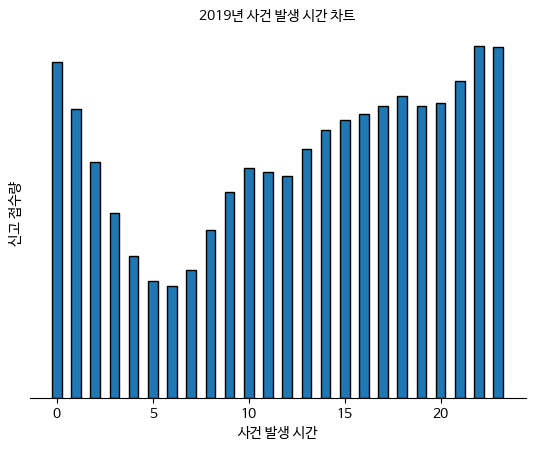

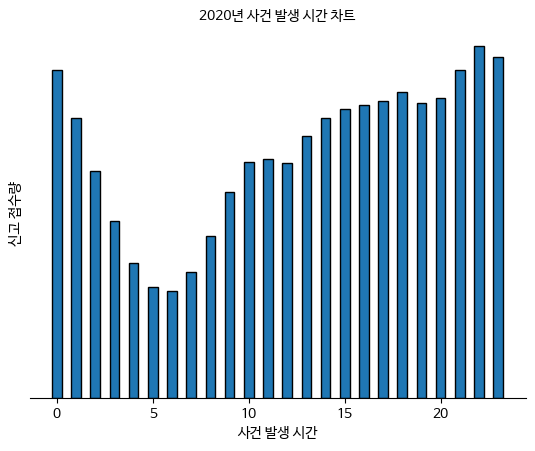

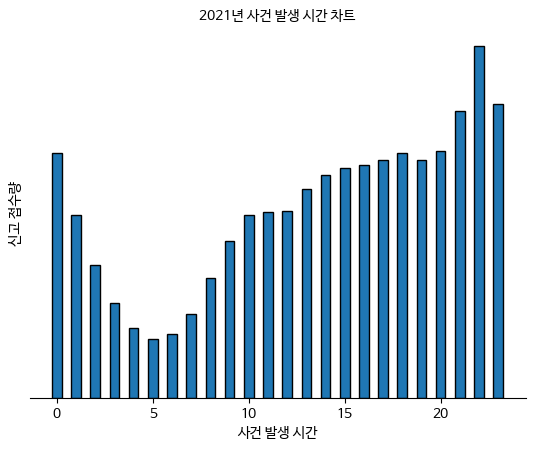

In [23]:
def draw_barplot(year_df, year):
  report_cnt = [year_df[x].sum() for x in hours]  
  plt.bar(time, report_cnt, width = 0.5, edgecolor='black')

  plt.title(f'전국 {year}년 사건 발생 시간 차트', fontsize = 10)
  plt.xlabel('사건 발생 시간', fontsize = 10)
  plt.ylabel('신고 접수량', fontsize = 10)
  plt.yticks(ticks= [])

  plt.gca().spines['right'].set_visible(False) #오른쪽 테두리 제거
  plt.gca().spines['top'].set_visible(False) #위 테두리 제거
  plt.gca().spines['left'].set_visible(False) #왼쪽 테두리 제거

  plt.show()
  print('\n'*3)
  return

for j in range(3):
  draw_barplot(div_year[j], year[j])

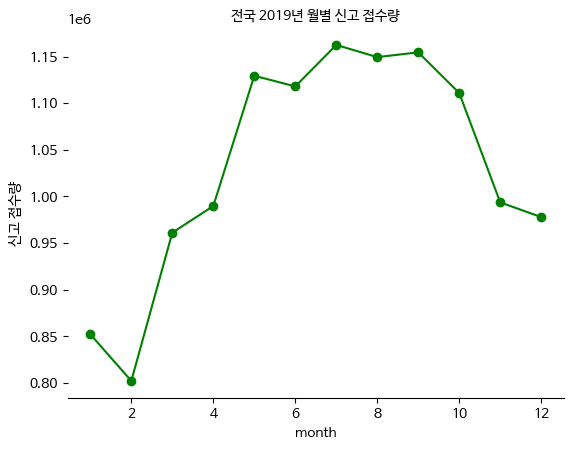

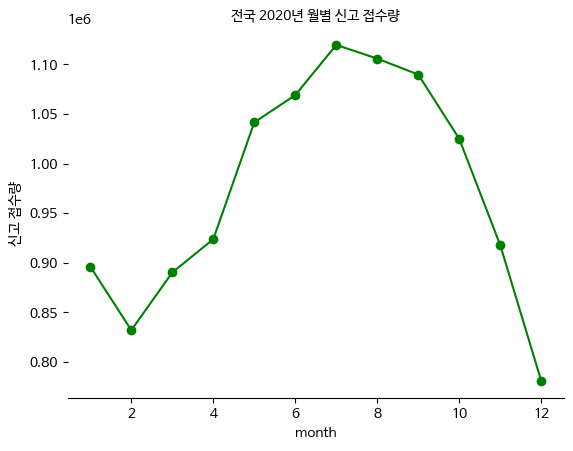

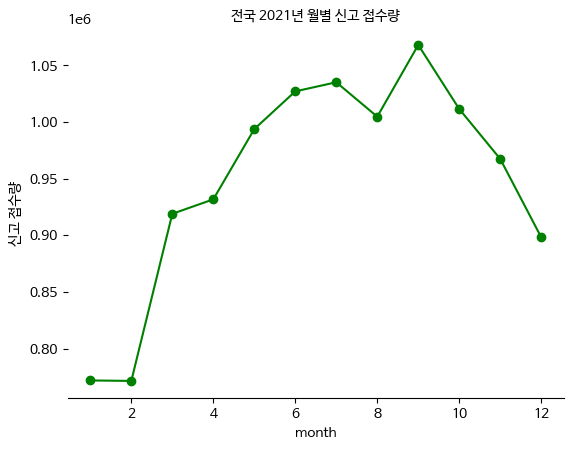

In [37]:
def draw_piplot(year_df, year):
  report_sum = [year_df[year_df['Month'] == x]['RPRT_CASCNT_WHOL'].sum() for x in month]

  plt.gca().spines['right'].set_visible(False) #오른쪽 테두리 제거
  plt.gca().spines['top'].set_visible(False) #위 테두리 제거
  plt.gca().spines['left'].set_visible(False) #왼쪽 테두리 제거

  plt.plot(month, report_sum, marker='o', color = 'g')
  plt.title(f'전국 {year}년 월별 신고 접수량', fontsize = 10)
  plt.xlabel('month', fontsize = 10)
  plt.ylabel('신고 접수량', fontsize = 10)
  plt.show()

  print('\n'*3)
  return


for j in range(3):
  draw_piplot(div_year[j], year[j])

### incheon 시각화

In [29]:
# 인천 경찰관서 필터링
incheon_df = df[df['PLCST_NM'].str.contains('인천')]

In [31]:
incheon_df.shape

(418, 52)

In [ ]:
polices = list(df.PLCST_NM.unique())
address = [
    '인천 강화군 동문안길 17 인천강화경찰서',
    '인천 계양구 계산새로 68 계양경찰서',
    '인천 중구 공항로 271 서편 2층',
    '인천 남동구 비류대로762번길 10 남동경찰서',
    '인천 남동구 논현고잔로 239',
    '인천 미추홀구 매소홀로290번길 32 인천미추홀경찰서',
    '인천 부평구 길주로 511 부평경찰서',
    '인천 부평구 굴포로 104 삼산경찰서',
    '인천 서구 탁옥로 77 인천 서부경찰서',
    '인천 연수구 원인재로 138',
    '인천 중구 제물량로 237',
    '인천 남동구 예술로152번길 9 인천경찰청'
]

district = ['Ganghwa-gun', 'Gyeyang-gu', 'Jung-gu', 'Namdong-gu', 'Namdong-gu', 'Nam-gu', 'Bupyeong-gu', 'Bupyeong-gu ', 'Seo-gu', 'Yeonsu-gu', 'Jung-gu', 'Dong-gu']

map_df = pd.DataFrame({'name':polices, 'address':address, 'district':district})
map_df

# import requests
# lat, lng = [], []
# for i, addr in enumerate(map_df['address']):
#     url = 'https://dapi.kakao.com/v2/local/search/address.json?query={}'.format(addr)
#     headers = {"Authorization": "KakaoAK 8a41302d9250e8cce2875611a5327245"}
#     result = requests.get(url, headers = headers).json()
#     lat.append(result["documents"][0]["x"])
#     lng.append(result["documents"][0]["y"])
  
# map_df['lat'] = lat
# map_df['lng'] = lng

In [ ]:
map_df.drop(map_df[map_df['name'] == "인천국제공항경찰단"].index , inplace=True)
map_df

In [ ]:
for i in range(3):
  year_df = div_year[i]
  new_year = year[i]
  map_df[new_year] = [year_df[year_df['PLCST_NM'] == x]['RPRT_CASCNT_WHOL'].sum() for x in map_df['name']]

map_df

In [ ]:
# json파일로 존재하는 대한민국을 구역으로 나누어놓은 파일
import urllib.request
with urllib.request.urlopen('https://raw.githubusercontent.com/southkorea/southkorea-maps/master/kostat/2018/json/skorea-municipalities-2018-geo.json') as url:
                            dt = json.loads(url.read().decode())
                         
json_string = json.dumps(dt)

f = open('geo_json', 'w')
f.write(json_string)
f.close()
f = open("./geo_json", 'r')
geo = json.loads(f.read())

In [ ]:
map_19 = folium.Map(
    location = [37.4562557,	126.7052062],
    tiles = "CartoDB positron",
    zoom_start=13,
)

folium.Choropleth(
    geo_data = geo,
    data = map_df,
    columns = ('district', 2019),
    key_on = 'feature.properties.name_eng',
    fill_color='YlOrBr',
    fill_opacity=0.7,
    line_opacity=1,
    line_weight=1.5,
    legend_name = '2019 구별 사건접수량',
    highlight = True

).add_to(map_19)

map_19

In [ ]:
df.head()

In [ ]:
predict_df = df[['ACPT_YM', 'PLCST_NM', 'RPRT_CASCNT_WHOL']]

In [ ]:
map_df

In [ ]:
predict_df.drop(predict_df[predict_df['PLCST_NM'] == '인천국제공항경찰단'].index, inplace = True)

In [ ]:
predict_df.reset_index(drop = True, inplace = True)

In [ ]:
predict_df

In [ ]:
def find_region(x, y):
  return map_df.loc[map_df.index[map_df['name'] == x].tolist()[0]]['district']

region = []

for i in range(len(predict_df)):
  region.append(find_region(predict_df.loc[i, "PLCST_NM"], map_df))

predict_df['region'] = region

In [ ]:
predict_df.isnull().sum()

In [ ]:
predict_df

In [ ]:
predict_df.to_csv("/content/drive/MyDrive/데이터마이닝/predict_112.csv")